In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from fishchips.experiments import CMB_Primary
from fishchips.cosmo import Observables
import fishchips.util

from classy import Class  # CLASS python wrapper
import numpy as np
import matplotlib.pyplot as plt
default_color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [11]:
# create an Observables object to store information for derivatives
pars = np.array( ['omega_b', 'omega_cdm', 'h',  'A_s', 'n_s', 'tau_reio', 'sum_mnu'])
centers = np.array([0.02222,  0.1197,  0.69,  2.1955e-9, 0.9655, 0.06, 0.06])
left_steps = np.array([0.0001, 0.001,   0.01,   0.01e-9, 0.005, 0.02, 0.0])
right_steps = np.array([0.0001, 0.001,   0.01,   0.01e-9, 0.005, 0.02, 0.01])

obs = Observables(parameters=pars,
                  fiducial=centers,
                  left=centers-left_steps,
                  right=centers+right_steps)

# generate a template CLASS python wrapper configuration
classy_template = {'output': 'tCl pCl lCl',
                   'l_max_scalars': 2500,
                   'lensing': 'yes',
                   'non linear': 'halofit'}
classy_template.update(fishchips.util.PRECISE_CLASS_DICT)

# add in the fiducial values too
classy_template.update(dict(zip(obs.parameters, obs.fiducial)))

In [12]:
# generate the fiducial cosmology
obs.compute_cosmo(key='CLASS_fiducial',
                  classy_dict=fishchips.util.neutrino_dict(classy_template))

# generate an observables dictionary, looping over parameters
for par, par_left, par_right in zip(obs.parameters, obs.left, obs.right):
    classy_left = classy_template.copy()
    classy_left[par] = par_left
    classy_right = classy_template.copy()
    classy_right[par] = par_right
    # pass the dictionaries full of configurations to get computed
    obs.compute_cosmo(key=par + '_CLASS_left',
                      classy_dict=fishchips.util.neutrino_dict(classy_left))
    obs.compute_cosmo(key=par + '_CLASS_right',
                      classy_dict=fishchips.util.neutrino_dict(classy_right))

In [21]:
import fishchips.cmb_lensing

In [20]:
! export PYTHONPATH="${PYTHONPATH}:/home/zequnl/Installs/enlib"

In [24]:
S3_wide = fishchips.experiments.get_PlanckPol_combine() + \
    [fishchips.experiments.CMB_Primary(
        theta_fwhm=(1.4,), sigma_T=(8.0,), sigma_P=(11.3,), f_sky=0.4),
    fishchips.cmb_lensing.CMB_Lensing_Only()]
    


Generating theory Cls...
Loaded cached Cls from  output/clsAll_low_acc_False_3000_20180726.pkl
Loaded cached Cls from  output/clphi_low_acc_False_3000_20180726.txt


ValueError: Maximum allowed size exceeded

/home/zequnl/Projects/fishchips-public/fishchips/experiments.py:194: RuntimeWarning: invalid value encountered in true_divide
  (cl_right[spec_xy] - cl_left[spec_xy]) / dx


ValueError: Axis limits cannot be NaN or Inf

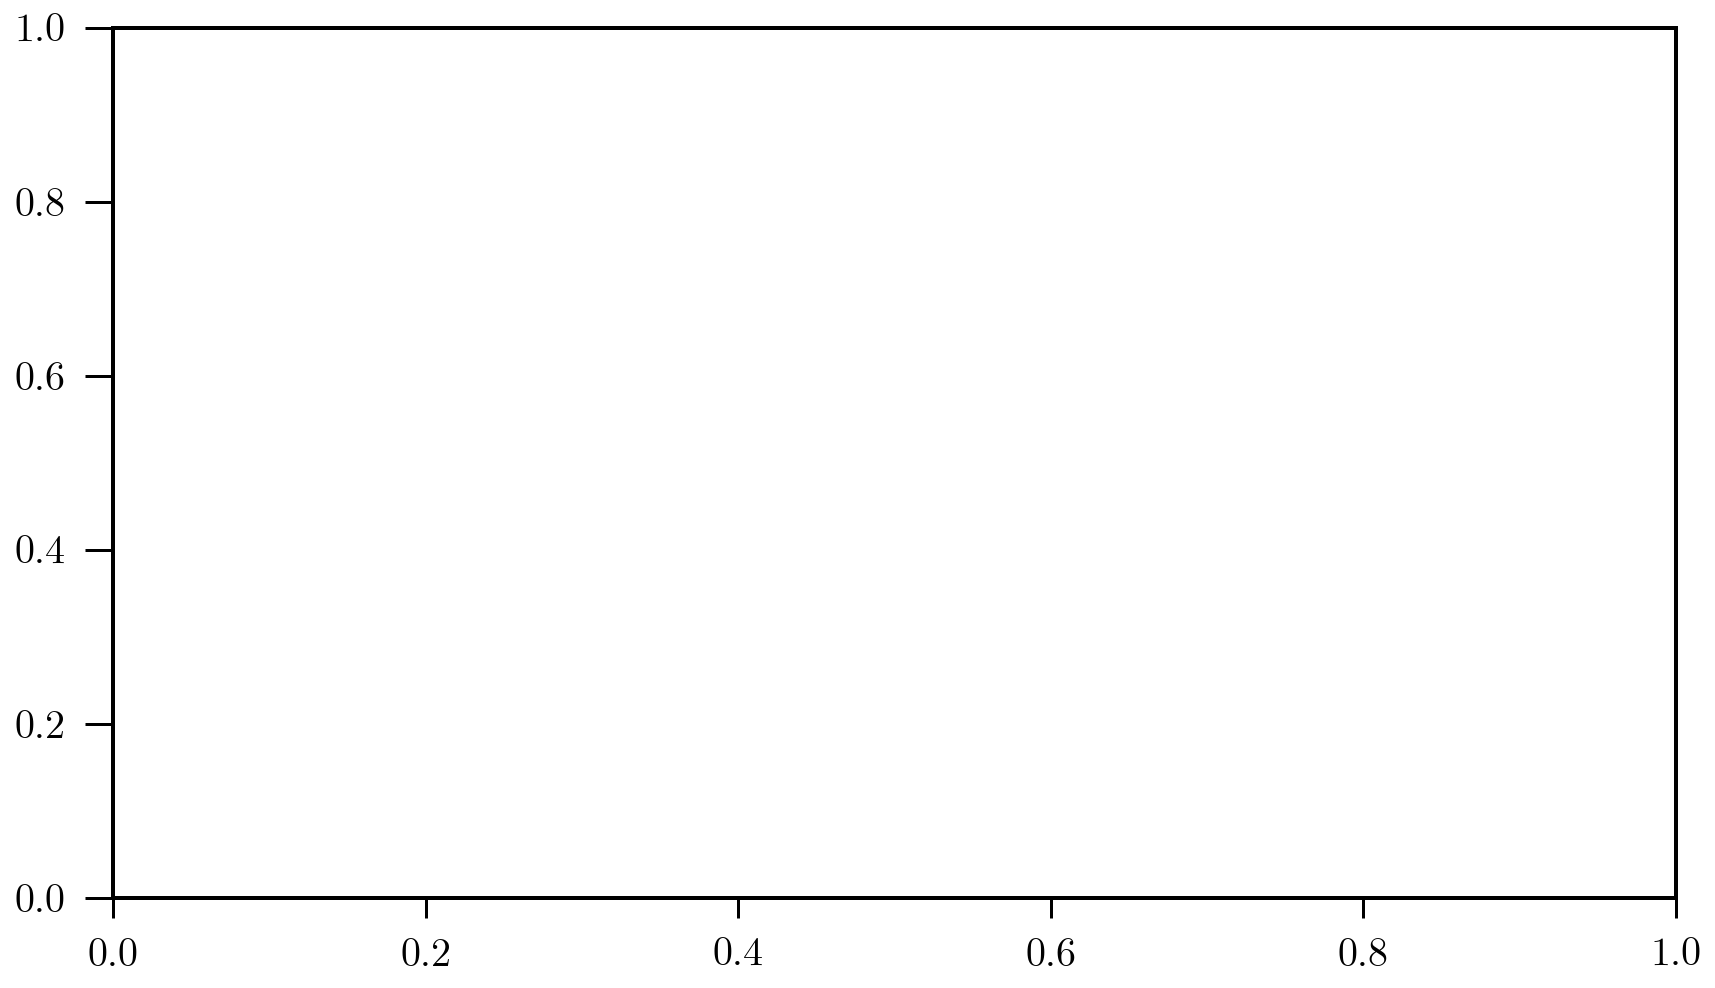

In [9]:
single_fig, single_ax = plt.subplots(figsize=(14,8))
fisher = np.sum( [exp.get_fisher(obs, lensed_Cl=False) for exp in S3_wide], axis=0 )
cov = np.linalg.inv(fisher)
fishchips.util.plot_ellipse(single_ax, 'sum_mnu', 'omega_cdm', obs, cov)

In [ ]:
single_fig, single_ax = plt.subplots(figsize=(14,8))


allison_S4.plot_ellipse(single_ax, 'mnu', 'omega_cdm', 
                        color=default_color_list[0],
                       one_sigma_only=True, ls1='-')
allison_S4_DESI.plot_ellipse(single_ax, 'mnu', 'omega_cdm', 
                        color=default_color_list[0],
                       one_sigma_only=True, ls1='--')
allison_Planck.plot_ellipse(single_ax, 'mnu', 'omega_cdm', 
                        color=default_color_list[2],
                       one_sigma_only=True, ls1='-')
allison_Planck_BAO.plot_ellipse(single_ax, 'mnu', 'omega_cdm', 
                        color=default_color_list[2],
                       one_sigma_only=True, ls1='--')

allison_S3.plot_ellipse(single_ax, 'mnu', 'omega_cdm', 
                        color=default_color_list[3],
                       one_sigma_only=True, ls1='-')
allison_S3_DESI.plot_ellipse(single_ax, 'mnu', 'omega_cdm', 
                        color=default_color_list[3],
                       one_sigma_only=True, ls1='--')

single_ax.set_xlim(0.0, 0.5)
single_ax.set_ylim(0.117, 0.123)
single_ax.set_ylabel(r'$\Omega_c h^2$')
single_ax.set_xlabel(r'$\sum M_{\nu}$ (eV)')

# single_ax.set_xticks([0.0,0.4,0.8,1.2,1.6])

l1, = single_ax.plot([],[],'-',color=default_color_list[0])
l2, = single_ax.plot([],[],'--',color=default_color_list[0])
l3, = single_ax.plot([],[],'-',color=default_color_list[2])
l6, = single_ax.plot([],[],'--',color=default_color_list[2])
l4, = single_ax.plot([],[],'-',color=default_color_list[3])
l5, = single_ax.plot([],[],'--',color=default_color_list[3])

single_ax.legend( [l1, l2,l3,l6, l4, l5], \
                    [r'S4', r'S4+DESI', 'Planck-Pol', 'Planck-Pol + BAO2015', 'S3-wide', 'S3-wide + DESI'], \
              loc = 'upper right', ncol=1 );

single_ax.plot( [0.06],[0.1197], 'kx')

plt.tight_layout()
plt.savefig('figures/testing_allison_fig_4.pdf')
